In [1]:
# Note that the unet_model.py used in this tutorial is only for demonstration.
# The original author of unet_model.py is Supervisely.
# Please check README and unet_model.py for the term of usage.
# You can change the model here with other weights for personal use.

In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np

import requests
import copy

from unet_model import construct_unet

from PIL import Image
from imutils.paths import list_images

In [2]:
from pv_vision.nn import ModelHandler

In [3]:
# load images
images = [cv.imread(file) for file in list_images('../examples/crack_segmentation/img_for_prediction')]

In [4]:
# def image dataset
class myDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv.resize(self.images[idx], (256, 256))
        image = self.transform(image)
        
        return image

In [5]:
# define image loader which is passed into modelhandler
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

imgset = myDataset(images, transform)


In [6]:
# download the pretrained model weights from 
# https://datahub.duramat.org/dataset/a1417b84-3724-47bc-90b8-b34660e462bb/resource/45da3b55-fa96-471d-a231-07b98ec5dd8e/download/crack_segmentation.zip
# You need to unzip the file to get the .pt weight

# Here is a simple way to get the weight file
url = 'https://datahub.duramat.org/dataset/a1417b84-3724-47bc-90b8-b34660e462bb/resource/45da3b55-fa96-471d-a231-07b98ec5dd8e/download/crack_segmentation.zip'
response = requests.get(url)
open('model_weights.zip', 'wb').write(response.content)

# after you unzip this file, the model.pt file is inside unet_oversample_low_final_model_for_paper
# you will need GPU to use this weight
weight_path = 'unet_oversample_low_final_model_for_paper/model.pt'

In [7]:
!unzip model_weights.zip

Archive:  model_weights.zip
   creating: unet_oversample_low_final_model_for_paper/
  inflating: __MACOSX/._unet_oversample_low_final_model_for_paper  
  inflating: unet_oversample_low_final_model_for_paper/model.pt  
  inflating: __MACOSX/unet_oversample_low_final_model_for_paper/._model.pt  
  inflating: unet_oversample_low_final_model_for_paper/config.json  
  inflating: __MACOSX/unet_oversample_low_final_model_for_paper/._config.json  


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = construct_unet(5)
unet = DataParallel(unet)

In [9]:
# initialize modelhandler
# The output is stored in the output folder
modelhandler = ModelHandler(
    model=unet,
    test_dataset=imgset,
    predict_only=True,
    batch_size_val=2,
    device=device,
    save_dir='output',
    save_name='unet_prediction'
)
modelhandler.load_model(weight_path)

In [10]:
# run the model
masks = modelhandler.predict(save=True)

100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


## Visualize the predicted masks

Some functions defined here will be included in the utils.py in the future

In [11]:
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])
color_map = {
    'dark': (68, 114, 148),
    'cross': (77, 137, 99),
    'crack': (165, 59, 63),
    'busbar': (222, 156, 83)
}

def get_masks(masks_raw):
    # masks_raw has the shape batch x n_masks x img_h x img_w, its elements are probability of prediction
    # masks_each has the shape batch x n_masks x img_h x img_w, its elements are boolen (whether belongs to this mask)
    masks_each = []
    # masks_all has the shape batch x img_h x img_w, its elements are labels of masks.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        cross = masks==3
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return masks_each

def draw_mask(img, masks, colors=color_map, alpha=0.6):
    img = Image.fromarray(img)
    img = resize(img)

    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'cross', 'dark']])
    return F.to_pil_image(combo)


In [12]:
masks_each = get_masks(masks)

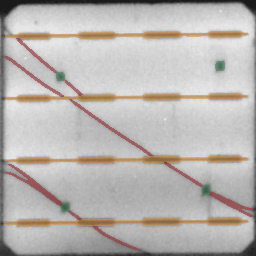

In [13]:
draw_mask(images[2], masks_each[2])

# Done!